**Reinforcement Learning**

1. Modify the q-learning program given in the class to solve the below situation. 
Problem setting
Consider an 8x8 grid for robot navigation. The agent has 8 possible actions in each 
state (grid square): From the current grid, possible actions include move to a grid north, 
south, east, west, north-east, north-west, south-east and south-west. If the direction of 
movement is blocked, the agent remains in the same grid square. 
The initial state of the agent is IS (8,8) at the bottom. Three terminal states: G, S and 
D. Gold state G and Silver state S has rewards 10 and 5 respectively. A danger state D 
has -10 reward. All other states have a reward of -1.

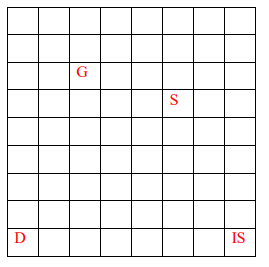

a. Execute the q-learning algorithm for 100 iterations with epsilon=0.05, alpha=0.7, 
gamma=.6  
b. Compare the reward acquired by a random agent and q-learning agent  
c. Comment on the values in q-table for first 10 and last 10 iterations.   
d. Check the convergence of this algorithm.  
e. Assume that the positions of G and S move to another location (one row up or 
one row down) during learning phase after every 10th iteration. (To simulate this, 
modify reward matrix, put the corresponding reward in new cell). Execute the 
algorithm in this context and comment on the learning process. Compare the 
rewards earned by a random agent and q-learning agent.  
f. Execute the sarsa algorithm till convergence (check the reward curve and fix the 
number of iterations). Plot the reward acquired by the agent.  
g. Plot the current location (x vs y) of agent in the learning phase.(hint: this is the 
path followed by the agent)  
h. Compare the learning curve and path followed by the agent for q-learning and 
sarsa.  

In [15]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
class GridWorld:
    def __init__(self):
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        # Set random start location for the agent
        self.current_location = (4, np.random.randint(0,8))
        
        # Set locations for the bomb and the gold
        self.danger_location = (7,0)
        self.gold_location = (0,2)
        self.silver_location = (3,5)
        self.terminal_states = [self.danger_location,self.gold_location,self.silver_location]
        
        # Set grid rewards for special cells
        self.grid[ self.danger_location[0], self.danger_location[1]] =-10
        self.grid[ self.gold_location[0], self.gold_location[1]] =10
        self.grid[ self.silver_location[0],self.silver_location[1]]=5
        
        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    
        
    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        
        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [17]:
class RandomAgent():        
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions) 

In [18]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.7, gamma=0.6):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def learn(self, old_state, reward, new_state, action):
        """Updates the Q-value table using Q-learning"""
        q_values_of_state = self.q_table[new_state]
        max_q_value_in_new_state = max(q_values_of_state.values())
        current_q_value = self.q_table[old_state][action]
        
        self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)


In [19]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True     
                
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        
    return reward_per_episode # Return performance log

In [20]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 5)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = (4, 4)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


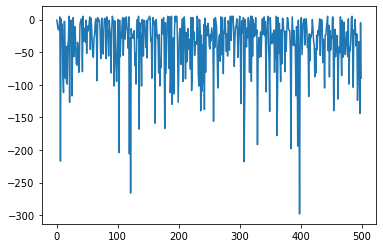

In [21]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

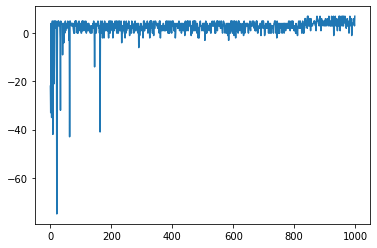

In [24]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=1000, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

In [25]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))
        
pretty(agentQ.q_table)

(0, 0)
	UP
		0
	DOWN
		-0.7
	LEFT
		0
	RIGHT
		2.912
(0, 1)
	UP
		0
	DOWN
		-0.9939999999999999
	LEFT
		0.24079999999999988
	RIGHT
		9.100000000000001
(0, 2)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		9.73
	RIGHT
		0
(0, 4)
	UP
		0
	DOWN
		-0.7
	LEFT
		-0.7
	RIGHT
		-0.9939999999999999
(0, 5)
	UP
		-1.204
	DOWN
		-0.7
	LEFT
		-0.9099999999999999
	RIGHT
		-0.9939999999999999
(0, 6)
	UP
		-1.204
	DOWN
		-0.9939999999999999
	LEFT
		-0.9099999999999999
	RIGHT
		-0.9099999999999999
(0, 7)
	UP
		-1.204
	DOWN
		-0.7
	LEFT
		-1.204
	RIGHT
		-1.204
(1, 0)
	UP
		-0.9099999999999999
	DOWN
		-1.0821999999999998
	LEFT
		-1.204
	RIGHT
		-1.3740999999999999
(1, 1)
	UP
		-0.9099999999999999
	DOWN
		-1.204
	LEFT
		-1.2921999999999998
	RIGHT
		4.9982757691999975
(1, 2)
	UP
		10.0
	DOWN
		1.1899955547653696
	LEFT
		1.1823393764
	RIGHT
		0.030799999999999855
(1, 3)
	UP
		3.7940000000000005
	DOWN
		0
	LEFT
		-0.7
	RIGHT
		-0.7
(1, 4)
	UP
		-0.7
	DOWN
		-0.7
	LEFT
		-0.7
	RIGHT
